In [2]:
# Add project root to sys.path
import sys, os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from utils.vlm_inference_helper import Phi35, LlaVa16, InternVL25   # default setup from requirements.txt (require transformers==4.42.0)
# from utils.qwen_inference_helper import Qwen25                    # require newer transformers version (≥4.50.0) 
from utils.prompt_templates import PROMPT_TEMPLATES
from utils.process_vlm_io import process_pred_csv, get_chart_pair_images, data_alignment_str_to_json
from utils.evaluation_metrics import compute_grounding_metrics, compute_alignment_score
from utils.show_results import show_chart_grounding, show_chart_alignment

/cmlscratch/ani01/.conda/miniconda/envs/phi_3/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
from datasets import load_dataset

dataset = load_dataset("umd-zhou-lab/ChartAlignBench", "data_grounding_and_alignment")["test"]

In [4]:
sample = dataset[1906]
sample

{'idx': 1906,
 'imgname': 'bar_454',
 'chart_type': 'bar_chart',
 'num_cell_difference': 2,
 'chart_1_grounding': 'Region \t Number of Trees Planted(thousand) \t Number of Polluting Vehicles Removed(thousand) \n North America \t 100 \t 50 \n South America \t 120 \t 60 \n Europe \t 150 \t 70 \n Asia \t 130 \t 80 \n ',
 'chart_2_grounding': 'Region \t Number of Trees Planted(thousand) \t Number of Polluting Vehicles Removed(thousand) \n North America \t 100 \t 50 \n South America \t 120 \t 60 \n Europe \t 150 \t 32 \n Asia \t 187 \t 80 \n ',
 'alignment_json': '{"0": {"row name": "Europe", "column name": "Number of Polluting Vehicles Removed(thousand)", "value in chart 1": 70, "value in chart 2": 32}, "1": {"row name": "Asia", "column name": "Number of Trees Planted(thousand)", "value in chart 1": 130, "value in chart 2": 187}}',
 'image_pair': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2000x600>}

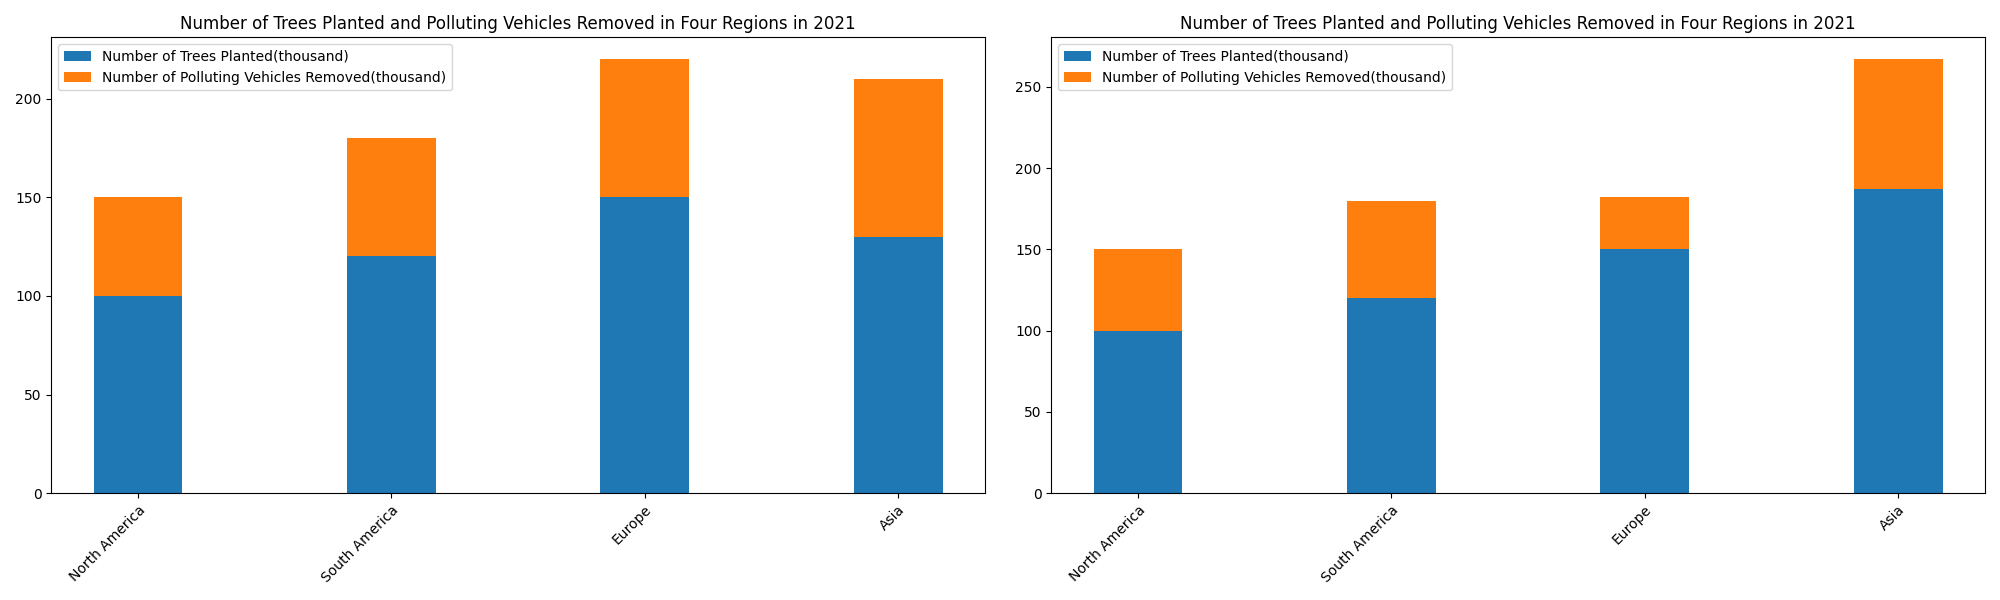

In [5]:
img = sample["image_pair"]
chart_1_img, chart_2_img = get_chart_pair_images(img)
img

In [6]:
VLM_obj = Phi35()

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- configuration_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- modeling_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/cmlscratch/ani01/.conda/miniconda/envs/phi_3/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:510: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
data_grounding_prompt = PROMPT_TEMPLATES["data"]["grounding"]

chart_1_pred_grounding = process_pred_csv(VLM_obj.infer(prompt_text_template = data_grounding_prompt, images_list = [chart_1_img]))
chart_2_pred_grounding = process_pred_csv(VLM_obj.infer(prompt_text_template = data_grounding_prompt, images_list = [chart_2_img]))

chart_1_gt_grounding = sample['chart_1_grounding']
chart_2_gt_grounding = sample['chart_2_grounding']

chart_1_grounding_score = compute_grounding_metrics(chart_1_gt_grounding, chart_1_pred_grounding, "data")
chart_2_grounding_score = compute_grounding_metrics(chart_2_gt_grounding, chart_2_pred_grounding, "data")

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


Region,Number of Trees Planted,Number of Polluting Vehicles Removed
North America,100,50
South America,120,60
Europe,150,70
Asia,130,80
Region,Number of Trees Planted,Number of Polluting Vehicles Removed
North America,100,50
South America,120,60
Europe,150,70
Asia,130,65
Region,Number of Trees Planted,Number of Polluting Vehicles Removed

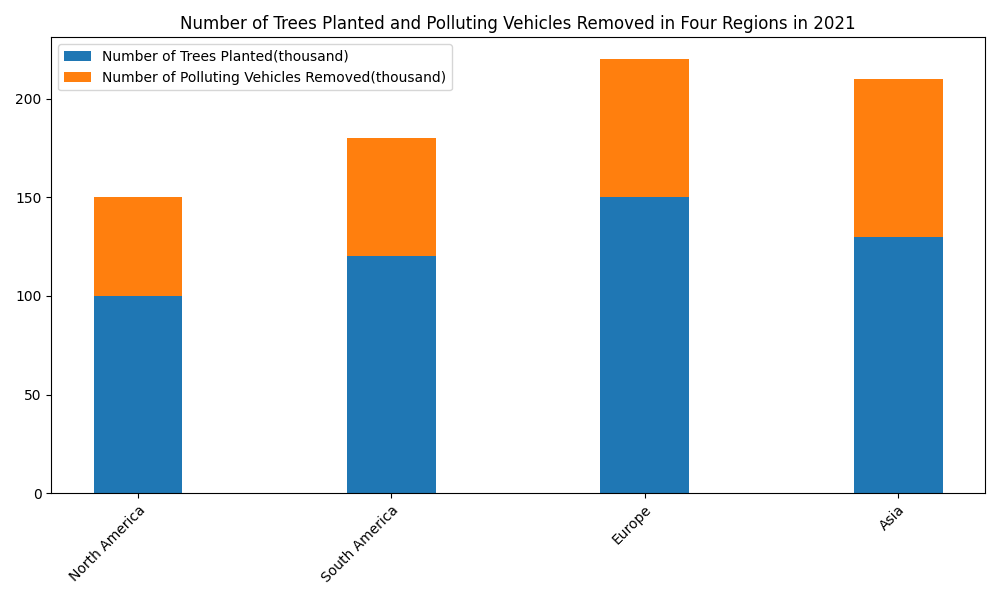
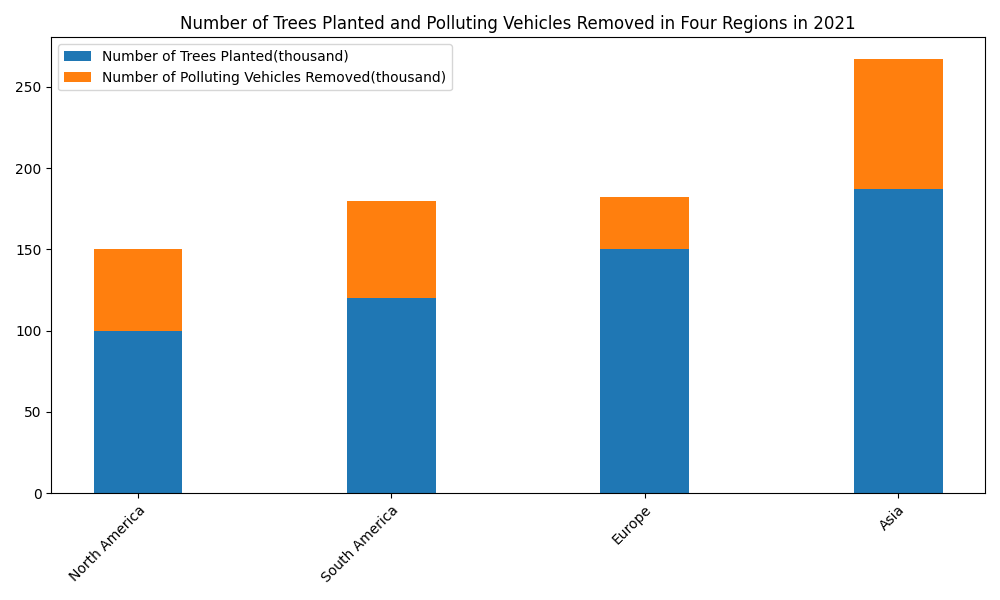

In [8]:

show_chart_grounding(chart_1_img, chart_2_img, chart_1_gt_grounding, chart_1_pred_grounding, chart_2_gt_grounding, chart_2_pred_grounding, chart_1_grounding_score, chart_2_grounding_score, content_type = "data")


In [9]:
import json

num_cell_difference = sample["num_cell_difference"]

data_alignment_prompt = PROMPT_TEMPLATES["data"]["alignment"]
data_alignment_prompt = data_alignment_prompt.replace("image_1_predicted_grounding_tag", chart_1_pred_grounding)
data_alignment_prompt = data_alignment_prompt.replace("image_2_predicted_grounding_tag", chart_2_pred_grounding)
data_alignment_prompt = data_alignment_prompt.replace("cells_change_cnt_tag", f"{num_cell_difference}")
if num_cell_difference == 1: # singular
    data_alignment_prompt = data_alignment_prompt.replace("cell(s)", "cell")
else:                     # plural
    data_alignment_prompt = data_alignment_prompt.replace("cell(s)", "cells")

pred_alignment_json = data_alignment_str_to_json(VLM_obj.infer(prompt_text_template = data_alignment_prompt), num_cell_difference)
gt_alignment_json = json.loads(sample['alignment_json'])

{'0': {'row name': 'Europe', 'column name': 'Number of Polluting Vehicles Removed(thousand)', 'value in chart 1': 70, 'value in chart 2': 32}, '1': {'row name': 'Asia', 'column name': 'Number of Trees Planted(thousand)', 'value in chart 1': 130, 'value in chart 2': 187}}
{0: {'row name': 'North America', 'column name': 'Number of Trees Planted (thousand)', 'value in chart 1': 100, 'value in chart 2': 120}, 1: {'row name': 'North America', 'column name': 'Number of Polluting Vehicles Removed (thousand)', 'value in chart 1': 50, 'value in chart 2': 30}}



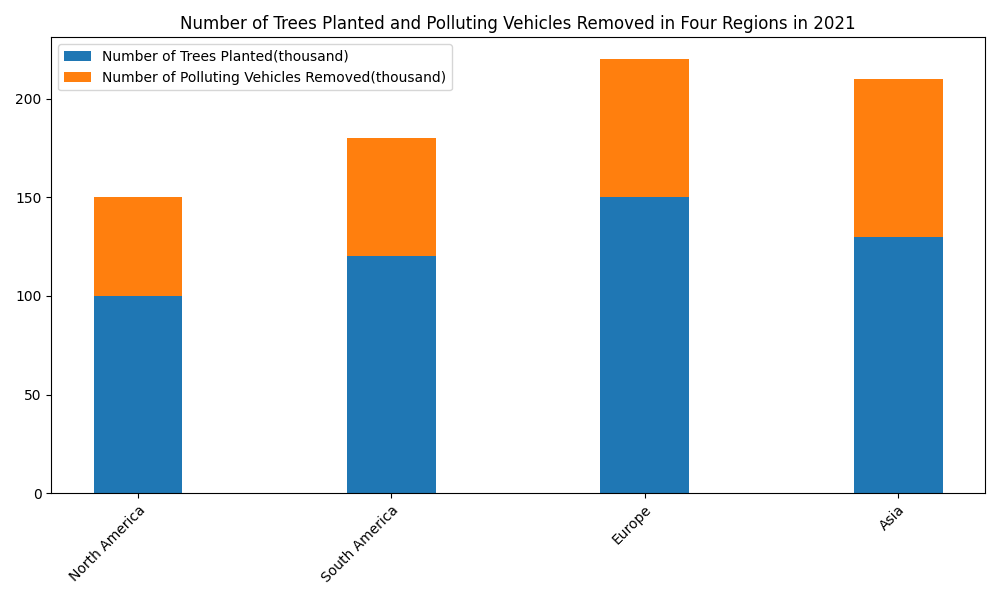
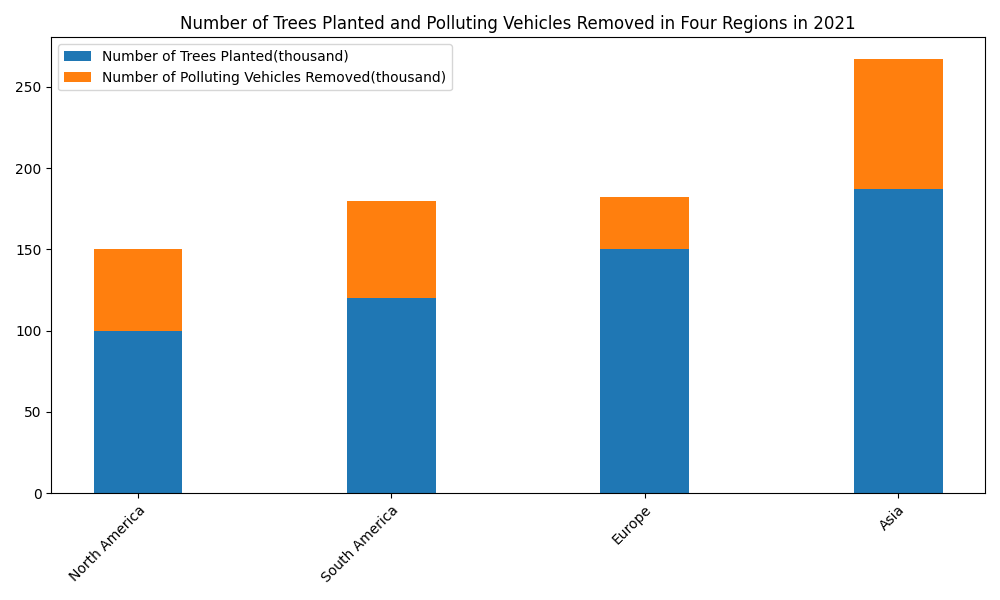

In [10]:
alignment_score = compute_alignment_score(gt_alignment_json, pred_alignment_json, "data")

show_chart_alignment(
    chart_1_img, chart_2_img, gt_alignment_json, pred_alignment_json, alignment_score
)
